### Preprocessing and EDA steps
- Find column types to identify categorical features that need one-hot encoding (FIXME)

- Evaluate RULs from assumptions about the training set and label files for the test set (OK)

- Scale all features and labels (OK)

- Bin labels(RULs) into discrete classes; long, medium, short, and urgent (OK)

- Binary and one-hot encode features (FIXME)

- Binary and one-hot encode labels (moved to the modeling part)

- Find the principal components (continuous, discrete) (OK, FIXME)

In [1]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.neighbors
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
current_palette_4 = sns.color_palette("hls", 4)
sns.set_palette(current_palette_4)
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Settings - Feel free to play!
## The provided training and test set are covering different ranges of RUL (in unit iof cycles), 
## so let's merge them and see how the model learns the behaviours then
merge_data = False
sn = 3 #Different data sets (1 to 4)
n_classes = 4 #number of classes to split RULs into

data_path = 'data'
plot_path = 'plots'
setnumber = 'FD00'+str(sn)
# number of PCA components
nc = 15

In [3]:
def read_set(data_path, setnumber, settype):
    name = os.path.join(data_path, settype+'_'+str(setnumber)+'.txt')
    data = pd.read_csv(name, delim_whitespace=True, header=None)
    new_cols = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + ['s'+str(x) for x in range(1, 26-4)]
    data.columns = new_cols
    return data

#FIXME! relies on pd dtype identification (not reliable!) and currently not in use!
def find_col_types(df):
    id_columns = ['id', 'cycle']
    df_columns = df.columns.difference(id_columns)
    categorical_columns = [x for x in df_columns if df[x].dtype=='int']
    scalable_columns = [x for x in df_columns if x not in categorical_columns]
    return categorical_columns, scalable_columns

#sequences in training set stop by the full failure, i.e. RUL=0
def calculate_train_RUL(df):
    for part_id in df['id'].unique():
        max_cycle = df.loc[df['id']==part_id, 'cycle'].max()
        df.loc[df['id']==part_id,'RUL'] = max_cycle - df.loc[df['id']==part_id, 'cycle']
    return df

def calculate_test_RUL(df, label_df):
    for part_id in df['id'].unique():
        max_cycle = df.loc[df['id']==part_id, 'cycle'].max()
        label_RUL = label_df.loc[label_df['id']==part_id, 'RUL'].values[0]
        df.loc[df['id']==part_id,'RUL'] = max_cycle + label_RUL + (max_cycle - df.loc[df['id']==part_id, 'cycle'])
    return df

def plot_all_measurements(df, plot_path='plots', plot_name='raw_sequences.png'):
    cols = df.columns[2:26]
    fig, axs = plt.subplots(len(cols), figsize=(15, 15))
    axs = axs.flatten()
    for i, col in enumerate(cols):
        axs[i].plot(df['cycle'], df[col], 'o', label=col)
        axs[i].legend(loc=1)
    plt.savefig(os.path.join(plot_path, plot_name))
    plt.show()
    
def plot_correlations(df, drop_cols=[], title='', plot_path='plots', plot_name='correlation.png'):
    tmp_df = df.drop(drop_cols, 1)
    corr = tmp_df.corr()
    plt.figure(figsize=(15, 15))
    g = sns.heatmap(corr)
    g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 8)
    g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 8)
    plt.title(title)
    plt.savefig(os.path.join(plot_path, plot_name))
    plt.show()


In [4]:
#Training set
train = read_set(data_path, setnumber, 'train')
cat_train, scale_train = find_col_types(train)

#Test set
test = read_set(data_path, setnumber, 'test')
cat_test, scale_test = find_col_types(test)

#Labels
label = pd.read_csv(os.path.join(data_path, 'RUL_'+setnumber+'.txt'), header=None)
label.reset_index(level=[0], inplace=True)
label.columns = ['id', 'RUL']
label['id'] = label['id'] + 1  #index is 0-bound but part_ids are 1-bound

#Add labels
train = calculate_train_RUL(train)
test = calculate_test_RUL(test, label)

#Make all values float
train = train.astype('float64')
test = test.astype('float64')

In [5]:
# Add training and test set to form a full set which is then used for more RUL range coverage
full = pd.concat([train, test], ignore_index=True)

if merge_data:
    del train, test
    train, validate, test = np.split(full.sample(frac=1), [int(.6*len(full)), int(.8*len(full))])
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    validate.reset_index(drop=True, inplace=True)
else:
    # split test set into test and validation sets
    msk = np.random.rand(len(test)) < 0.5
    validate = test[~msk].reset_index(drop=True)
    test = test[msk].reset_index(drop=True)
    
#Save intermediate file
if merge_data:
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_merge.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_merge.csv'), index=False)
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_merge.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_merge.csv'), index=False)
else:
    train.to_csv(os.path.join(data_path, 'train_'+setnumber+'.csv'), index=False)
    test.to_csv(os.path.join(data_path, 'test_'+setnumber+'.csv'), index=False)
    full.to_csv(os.path.join(data_path, 'full_'+setnumber+'.csv'), index=False)
    validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'.csv'), index=False)    

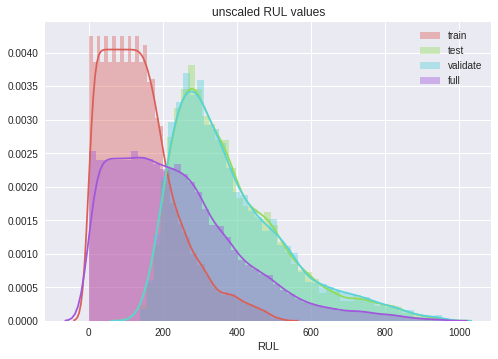

In [6]:
plt.figure()
sns.distplot(train.RUL, label='train')
sns.distplot(test.RUL, label='test')
sns.distplot(validate.RUL, label='validate')
sns.distplot(full.RUL, label='full')
plt.legend()
plt.title('unscaled RUL values')
if merge_data:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_unscaled_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, setnumber+'_RULs_unscaled.png'))
plt.show()

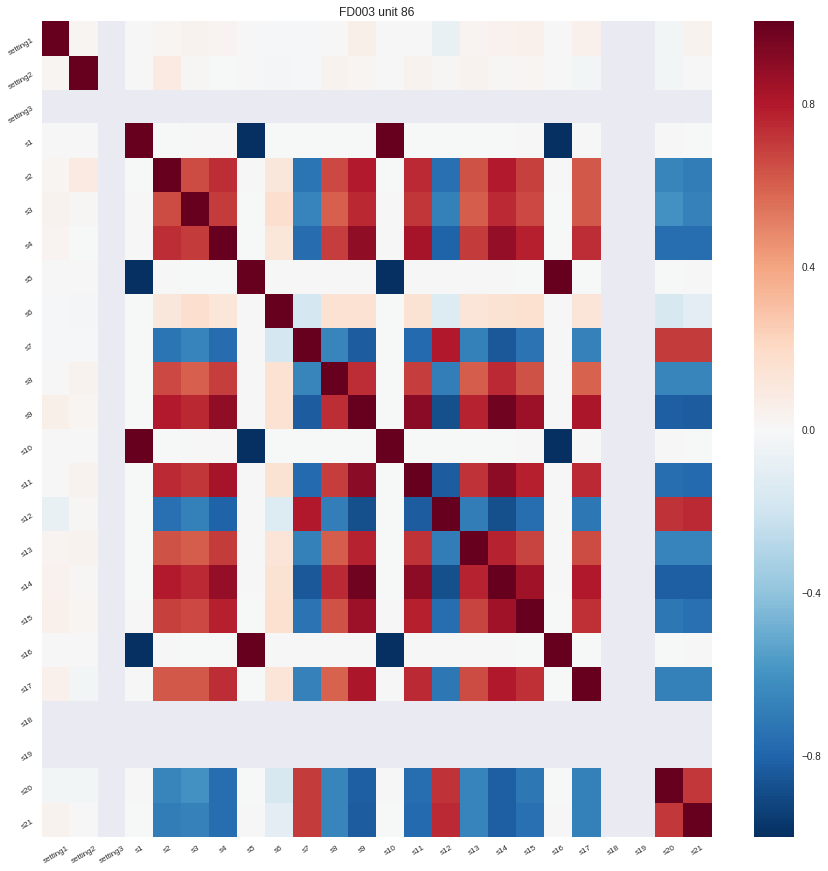

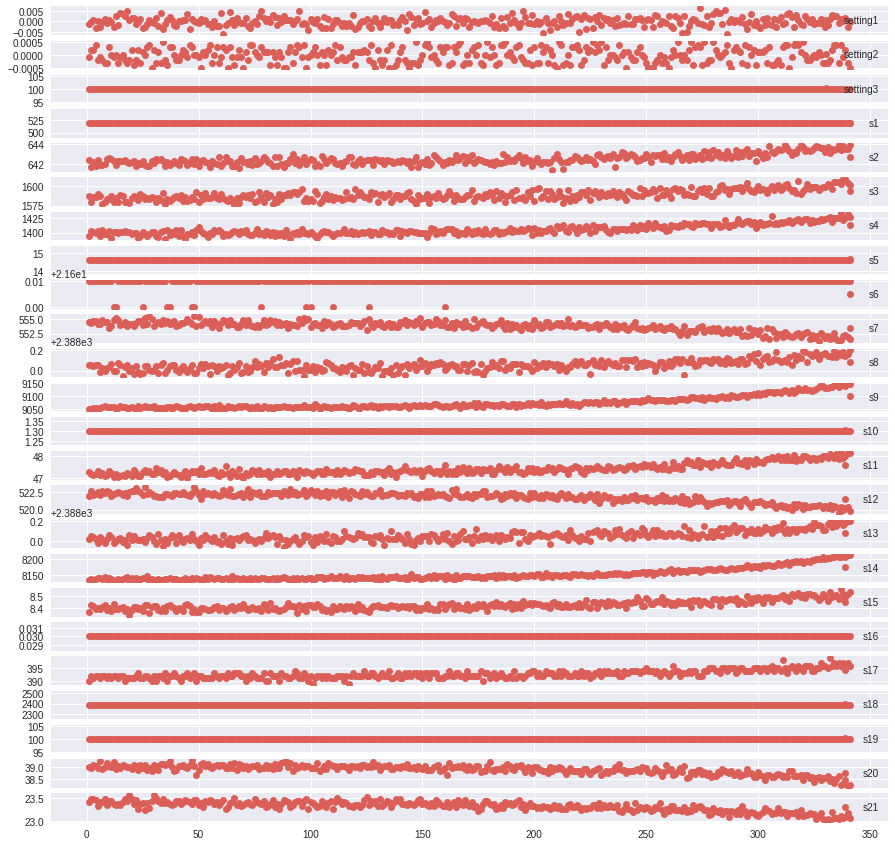

In [7]:
## plot correlations for unit i
i = np.random.randint(low=train.id.min(), high=train.id.max())
df = train.loc[train.id==i]
plot_correlations(df, drop_cols=['id', 'cycle', 'RUL'], 
                  title='%s unit %s'%(setnumber, i), plot_path=plot_path, plot_name=setnumber)
plot_all_measurements(df, plot_path='plots', plot_name='raw_sequences.png')

In [8]:
## SCALE DATA
#normalize features (using MinMaxScaler)
train_scalables = train[train.columns.difference(['id', 'cycle', 'status'])].values
test_scalables = test[test.columns.difference(['id', 'cycle', 'status'])].values
validate_scalables = validate[validate.columns.difference(['id', 'cycle', 'status'])].values
full_scalables = full[full.columns.difference(['id', 'cycle', 'status'])].values

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)

full_values = scaler.transform(full_scalables)
train_values = scaler.transform(train_scalables)
test_values = scaler.transform(test_scalables)
validate_values = scaler.transform(validate_scalables)
    
train[train.columns.difference(['id', 'cycle'])] = train_values
test[test.columns.difference(['id', 'cycle'])] = test_values
validate[validate.columns.difference(['id', 'cycle'])] = validate_values
full[full.columns.difference(['id', 'cycle'])] = full_values

In [9]:
# Bins for scaled RUL values corresponding to urgent, short, medium, long
RUL_min = full.RUL.min()
RUL_max = full.RUL.max()

bins = np.linspace(RUL_min-(RUL_max-RUL_min)/n_classes, RUL_max+RUL_min, n_classes+1)
status_labels = ['RUL%d'%x for x in range(n_classes)]

# bin RUL values
full['status'] = pd.cut(full['RUL'], bins, labels=status_labels)
train['status'] = pd.cut(train['RUL'], bins, labels=status_labels)
test['status'] = pd.cut(test['RUL'], bins, labels=status_labels)
validate['status'] = pd.cut(validate['RUL'], bins, labels=status_labels)

print n_classes
print bins
print status_labels

4
[-0.45706107  0.11426527  0.6855916   1.25691794  1.82824427]
['RUL0', 'RUL1', 'RUL2', 'RUL3']


In [10]:
## SEPARATE FEATURES AND LABELS
## Drop setting columns
full_X = full[full.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
full_y = full['status'].values

train_X = train[train.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
train_y = train['status'].values

test_X = test[test.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
test_y = test['status'].values

validate_X = validate[validate.columns.difference(['id', 'cycle', 'status', 'setting1', 'setting2', 'setting3'])].values
validate_y = validate['status'].values

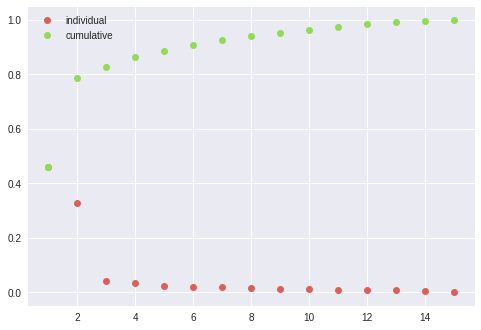

In [11]:
## COMPONENT ANALYSIS
pca = sklearn.decomposition.PCA(n_components=nc).fit(train_X)

fullX = pca.transform(full_X)
trainX = pca.transform(train_X)
testX = pca.transform(test_X)
validateX = pca.transform(validate_X)

evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()
plt.plot(range(1, nc+1), evals, 'o', label='individual')
plt.plot(range(1, nc+1), evals_cs, 'o', label='cumulative')
plt.legend()
plt.savefig(os.path.join(plot_path, 'PCA_variance_ratio.png'))
plt.show()

In [12]:
## PLOT SAMPLES ALONG THE FIRST 2 PRINCIPAL COMPONENTS
X_full = pd.DataFrame(fullX, columns=['comp_'+str(x) for x in range(1, fullX.shape[1]+1)])
X_full['RUL'] = full['RUL']
X_full['status'] = full['status']

X_train = pd.DataFrame(trainX, columns=['comp_'+str(x) for x in range(1, trainX.shape[1]+1)])
X_train['RUL'] = train['RUL']
X_train['status'] = train['status']

X_test = pd.DataFrame(testX, columns=['comp_'+str(x) for x in range(1, testX.shape[1]+1)])
X_test['RUL'] = test['RUL']
X_test['status'] = test['status']

X_validate = pd.DataFrame(validateX, columns=['comp_'+str(x) for x in range(1, validateX.shape[1]+1)])
X_validate['RUL'] = validate['RUL']
X_validate['status'] = validate['status']

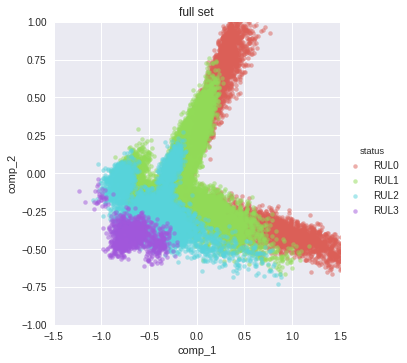

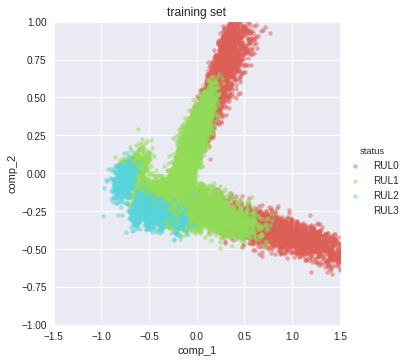

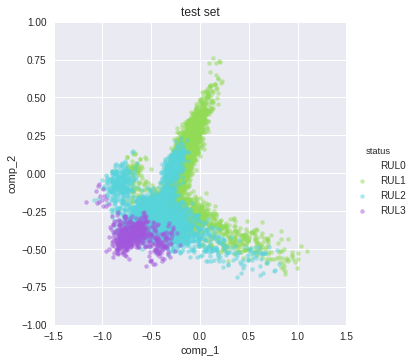

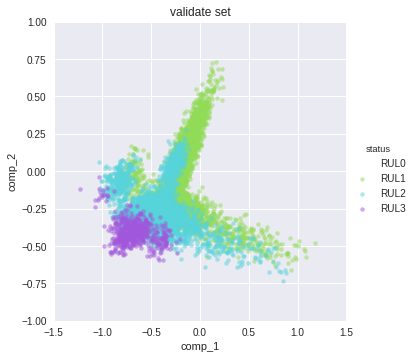

In [13]:
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_full, markers='o', scatter_kws={'alpha':0.5, 's':20})
plt.title('full set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'full_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'full_set.png'))
plt.show()

sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_train, markers='o', scatter_kws={'alpha':0.5, 's':20})
plt.title('training set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'training_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'training_set.png'))
plt.show()

sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_test, markers='o', scatter_kws={'alpha':0.5, 's':20})
plt.title('test set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'test_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'test_set.png'))
plt.show()

sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_validate, markers='o', scatter_kws={'alpha':0.5, 's':20})
plt.title('validate set')
plt.xlim(-1.5, 1.5)
plt.ylim(-1., 1.)
if merge_data:
    plt.savefig(os.path.join(plot_path, 'validate_set_merge.png'))
else:
    plt.savefig(os.path.join(plot_path, 'validate_set.png'))
plt.show()

In [14]:
# Save the preprocessed data
X_train['id'] = train['id']
X_train['cycle'] = train['cycle']
X_validate['id'] = validate['id']
X_validate['cycle'] = validate['cycle']
X_test['id'] = test['id']
X_test['cycle'] = test['cycle']

if merge_data:
    X_full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_PC_merge.csv'), index=False)
    X_train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_PC_merge.csv'), index=False)
    X_test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_PC_merge.csv'), index=False)
    X_validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC_merge.csv'), index=False)
else:
    X_full.to_csv(os.path.join(data_path, 'full_'+setnumber+'_PC.csv'), index=False)
    X_train.to_csv(os.path.join(data_path, 'train_'+setnumber+'_PC.csv'), index=False)
    X_test.to_csv(os.path.join(data_path, 'test_'+setnumber+'_PC.csv'), index=False)
    X_validate.to_csv(os.path.join(data_path, 'validate_'+setnumber+'_PC.csv'), index=False)

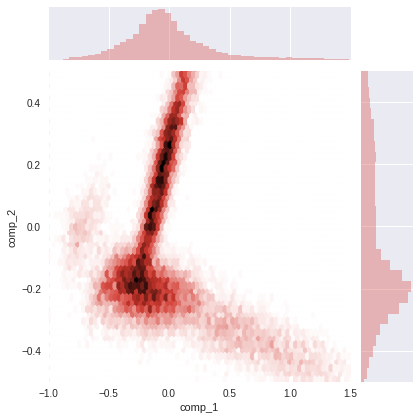

In [15]:
g = sns.jointplot(x='comp_1', y='comp_2', data=X_train, 
                      kind="hex", stat_func=None,
                     xlim=(-1.0, 1.5), ylim=(-0.5, 0.5))
plt.show()

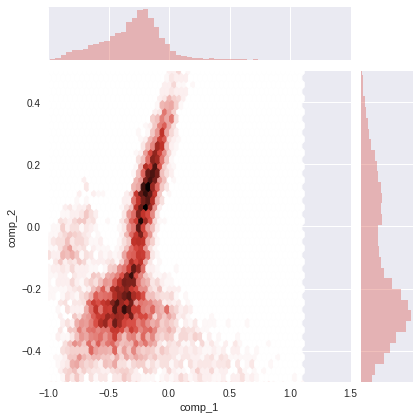

In [16]:
g = sns.jointplot(x='comp_1', y='comp_2', data=X_test, 
                      kind="hex", stat_func=None,
                     xlim=(-1.0, 1.5), ylim=(-0.5, 0.5))
plt.show()

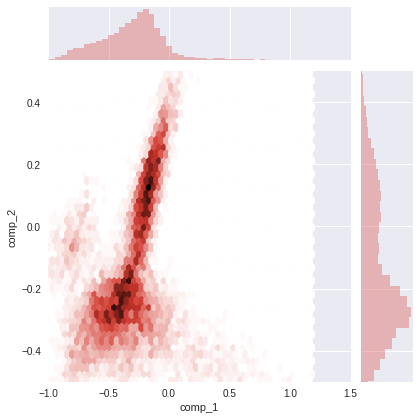

In [17]:
g = sns.jointplot(x='comp_1', y='comp_2', data=X_validate, 
                      kind="hex", stat_func=None,
                     xlim=(-1.0, 1.5), ylim=(-0.5, 0.5))
plt.show()